In [1]:
import ops
from ops.imports_ipython import *
import ops.firesnake
from ops.firesnake import Snake
from ops.qc import *
import seaborn as sns
from glob import glob
from microfilm import microplot
from microfilm.microplot import Micropanel
import matplotlib.pyplot as plt
import matplotlib

# Function to generate file paths
def generate_file_paths(well, tile):
    files = []
    
    # For PH, we typically have a single multichannel image per well/tile
    files.append([preprocess_pattern.format(well=well, tile=tile)])
    
    return files

# custom function to create segmentation colormap
def random_cmap(alpha=0.5, num_colors=256):
    """Create random colormap for segmentation"""
    
    colmat = np.random.rand(num_colors,4)
    colmat[:,-1] = alpha
    colmat[0, :] = [0, 0, 0, 1]  # Set the first color to black with full transparency
    cmap = matplotlib.colors.ListedColormap(colmat)

    return cmap

# GLASBEY_INVERTED = (ops.constants.GLASBEY_INVERTED)

### Set directory and ph parameters:

In [2]:
# Set screen directories
ph_function_home = "/lab/barcheese01/screens"
ph_function_dataset = "denali"
home = os.path.join(ph_function_home, ph_function_dataset)

# Change working directory to home
os.chdir(home)

# Create the directories
os.makedirs(os.path.join(home, 'ph_2/tif'), exist_ok=True)
os.makedirs(os.path.join(home, 'ph_2/csv'), exist_ok=True)

The following cell contains crucial variables that need to be set according to your specific experimental setup and data organization. Please review and modify these variables as needed before proceeding with the analysis.

- `WELLS` and `TILES`: The well and tile you want to analyze (for this notebook, we're using one well/tile combination for testing)
- `CHANNELS` and `preprocess_pattern`: The channel names and file naming conventions
- `DISPLAY_RANGES` and `LUTS`: The display ranges and color schemes (Look-Up Tables) for your image data

Ensure these variables accurately reflect your experimental setup to guarantee correct data processing and analysis.

In [3]:
# Set wells and tiles (in this notebook, one well / tile combination to test on)
WELLS = 'A1'
TILES = 186 
WILDCARDS = dict(well=WELLS, tile=TILES)

# Define channels
CHANNELS = None

# Define the file pattern
preprocess_pattern = 'input_ph_tif/20X_{well}_Tile-{tile}.phenotype.tif'

# Microplot information
DISPLAY_RANGES = [
    [500, 20000],
    [800, 5000],
    [800, 5000],
    [800, 5000]
]

# Define LUTs (Lookup Tables) for different channels
LUTS = [
    ops.io.GRAY,    # Lookup table for DAPI channel
    ops.io.GREEN,   # Lookup table for CY3 channel
    ops.io.RED,     # Lookup table for A594 channel
    ops.io.MAGENTA, # Lookup table for CY5 channel
    ops.io.CYAN     # Lookup table for CY7 channel
]

In [4]:
input_files = generate_file_paths(WELLS, TILES)
all_files = [item for sublist in input_files for item in sublist]

# Print the files
for f in all_files:
    print(f)
    
description = parse(all_files[0])
description.pop('tag')
description

input_ph_tif/20X_A1_Tile-186.phenotype.tif


{'subdir': 'input_ph_tif',
 'mag': '20X',
 'well': 'A1',
 'tile': '186',
 'ext': 'tif',
 'file': 'input_ph_tif/20X_A1_Tile-186.phenotype.tif'}

##### load file

In [5]:
input_image = read(all_files[0])
print(input_image.shape)

(4, 2400, 2400)


##### apply illumination correction

In [6]:
# Read the illumination correction files
icf_file = f'illumination_correction/20X_{WELLS}.phenotype.illumination_correction.tif'
correction = read(os.path.join(home, icf_file))

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = Snake._apply_illumination_correction(input_image, correction=correction)

##### align

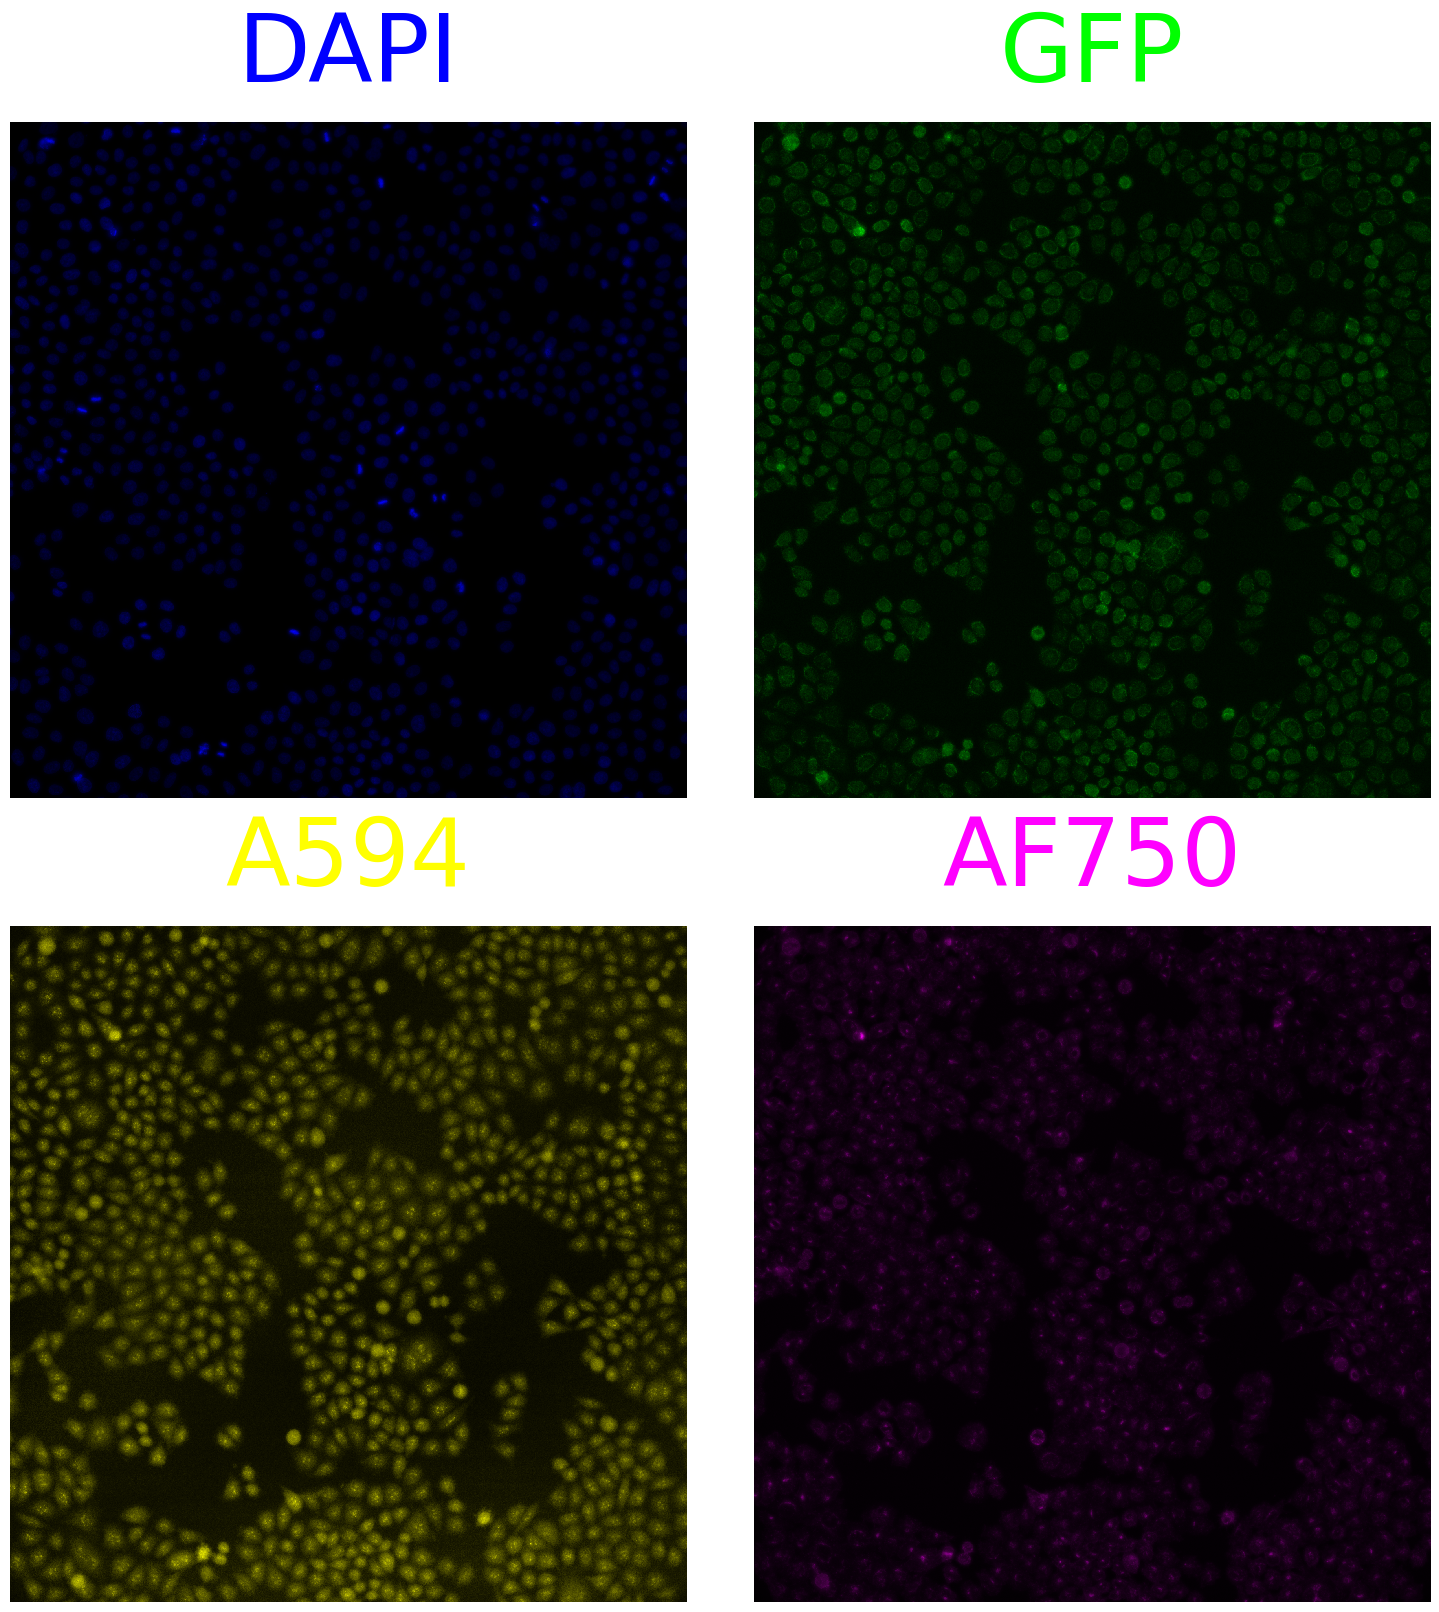

In [7]:
# show corrected
ph0_microshow = microplot.Microimage(corrected_image[0,:,:],
                                             cmaps = 'pure_blue',
                                             channel_names='DAPI')
ph1_microshow = microplot.Microimage(corrected_image[1,:,:],
                                             cmaps = 'pure_green',
                                             channel_names='GFP')
ph2_microshow = microplot.Microimage(corrected_image[2,:,:],
                                             cmaps = 'pure_yellow',
                                             channel_names='A594')
ph3_microshow = microplot.Microimage(corrected_image[3,:,:],
                                             cmaps = 'pure_magenta',
                                             channel_names='AF750')
panel = Micropanel(rows=2, cols=2, figscaling=8)
panel.add_element([0,0], ph0_microshow)
panel.add_element([0,1], ph1_microshow)
panel.add_element([1,0], ph2_microshow)
panel.add_element([1,1], ph3_microshow)
panel.add_channel_label()

The following cell contains important variables for preparing the image for Cellpose segmentation. Please review and adjust these variables based on your specific experimental setup before proceeding with the analysis.

- `DAPI_INDEX`: The index of the DAPI channel in your phenotyping image stack (0-indexed). Typically 0 for the DAPI channel.
- `CYTO_CHANNEL`: The index of the cytoplasmic channel in your phenotyping image stack (0-indexed). Typically the channel that best outlines cell boundaries, such as a membrane stain.

Ensure these variables accurately reflect the channel organization in your experimental phenotyping data to guarantee effective Cellpose segmentation.

In [8]:
# Define Cellpose segmentation parameters
DAPI_INDEX = 0 
CYTO_CHANNEL = 1

In [9]:
# Generate a file for testing Cellpose (this is wrapped into segmentation, and is not run in snakemake)
cellpose_rgb = Snake._prepare_cellpose(corrected_image, DAPI_INDEX, CYTO_CHANNEL)
print(cellpose_rgb.shape)
save(name(description, tag='prepared_cellpose', subdir='ph_2/tif'), cellpose_rgb)

(3, 2400, 2400)


/lab/barcheese01/mdiberna/OpticalPooledScreens/venv_ops_new/lib/python3.8/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


##### segment nuclei, cells, cytoplasm

There are three segmentation methods available:

1. **Cellpose method** (recommended):
   - Uses machine learning-based segmentation
   - Parameters: `NUCLEI_DIAMETER`, `CELL_DIAMETER`, `CYTO_MODEL`

2. **cell_2022 method**:
   - Uses adaptive thresholding and improved cell boundary detection
   - Parameters: `BACKGROUND_THRESHOLD_OFFSET`, `BACKGROUND_QUANTILE`, `CELL_COUNT_THRESHOLDS`, `BACKGROUND_EROSION`, `BACKGROUND_SMOOTH`

3. **cell_2019 method**: 
   - Uses simple thresholding and area constraints
   - Parameters: `THRESHOLD_DAPI`, `THRESHOLD_CELL`, `NUCLEUS_AREA`

Choose the appropriate method by setting the `SEGMENT_METHOD` variable to either "cellpose", "cell_2022", or "cell_2019".

Please review and adjust the segmentation parameters based on your calibration results and specific experimental setup before proceeding with the analysis.

For Cellpose segmentation, we strongly suggest calibrating via the Cellpose GUI. Follow these steps:

1. Open a terminal window
2. SSH onto fry: `ssh -Y your_username@fry.wi.mit.edu`
3. Activate a conda environment with cellpose[gui]: `conda activate ops_viewing`
4. Launch Cellpose: `python -m cellpose`
5. Open the prepared Cellpose image: `ph_2/tif/20X_well_Tile-nn.prepared_cellpose.tif`
6. Calibrate cyto3 model:
   - For cell diameter: use chan to segment = 2, chan2 = 3
   - For nuclei diameter: use chan to segment = 3, chan2 = 0

Note: You may want to adjust the diameter parameters and segment to test if you feel like you are capturing too little or too much area for either of the two masks.

In [11]:
# Define segmentation parameters
SEGMENT_METHOD = "cellpose"  # Options: "cellpose", "cell_2022", or "cell_2019"

# Parameters for cellpose method
NUCLEI_DIAMETER = 47.1  # User-specific: Calculated by running Cellpose calibration
CELL_DIAMETER = 55.3  # User-specific: Calculated by running Cellpose calibration
CYTO_MODEL = "cyto3"  # Cellpose model to use

# Parameters for cell_2022 method
BACKGROUND_CHANNEL = 3  # Index of channel used for cell boundary detection
BACKGROUND_THRESHOLD_OFFSET = 80  # Offset added to background intensity for thresholding
BACKGROUND_QUANTILE = {'low': 0.05, 'mid': 0.025, 'high': 0.01}  # Quantiles for adaptive thresholding
CELL_COUNT_THRESHOLDS = (1400, 2500)  # Min and max expected cell counts for quality control
BACKGROUND_EROSION = 50  # Pixels to erode from background mask
BACKGROUND_SMOOTH = 3  # Gaussian smoothing sigma for background

# Parameters for cell_2019 method 
THRESHOLD_DAPI = 2500  # Threshold for segmenting nuclei based on DAPI signal
THRESHOLD_CELL = 500  # Threshold for segmenting cells on phenotype background signal
NUCLEUS_AREA = (250, 3500)  # Min and max nucleus area

In [13]:
# This corresponds to the 'segment' rule in Snakemake
if SEGMENT_METHOD == "cellpose":
    data = corrected_image
    print(data.shape)    
    nuclei, cells = Snake._segment_cellpose(
        data=corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_CHANNEL,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cyto_model=CYTO_MODEL
    )
elif SEGMENT_METHOD == "cell_2022":
    data = corrected_image
    print(data.shape)    
    nuclei, cells = Snake._segment_cell_2022(
        data=corrected_image,
        nuclei_threshold=THRESHOLD_DAPI,
        nuclei_area_min=NUCLEUS_AREA[0],
        nuclei_area_max=NUCLEUS_AREA[1],
        channel=BACKGROUND_CHANNEL,
        background_offset=BACKGROUND_THRESHOLD_OFFSET,
        cell_count_thresholds=CELL_COUNT_THRESHOLDS,
        background_quantile=BACKGROUND_QUANTILE,
        smooth=BACKGROUND_SMOOTH,
        erosion=BACKGROUND_EROSION
    )
elif SEGMENT_METHOD == "cell_2019":
    data = corrected_image
    print(data.shape)    
    nuclei, cells = Snake._segment_cell_2019(
        data=corrected_image,
        nuclei_threshold=THRESHOLD_DAPI,
        nuclei_area_min=NUCLEUS_AREA[0],
        nuclei_area_max=NUCLEUS_AREA[1],
        cell_threshold=THRESHOLD_CELL
    )

else:
    raise ValueError(f"Invalid SEGMENT_METHOD: {SEGMENT_METHOD}. Choose 'cellpose', 'cell_2022', or 'cell_2019'.")

save(name(description, tag='nuclei', subdir='ph_2/tif'), nuclei, compress=1)
save(name(description, tag='cells', subdir='ph_2/tif'), cells, compress=1)

(4, 2400, 2400)


/lab/barcheese01/mdiberna/OpticalPooledScreens/venv_ops_new/lib/python3.8/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)
found 897 nuclei before removing edges
found 897 cells before removing edges


removing edges


found 834 nuclei before reconciling
found 817 cells before reconciling


reconciling masks with method how=consensus


found 805 nuclei/cells after reconciling


Number of nuclei segmented: 805
Number of cells segmented: 805


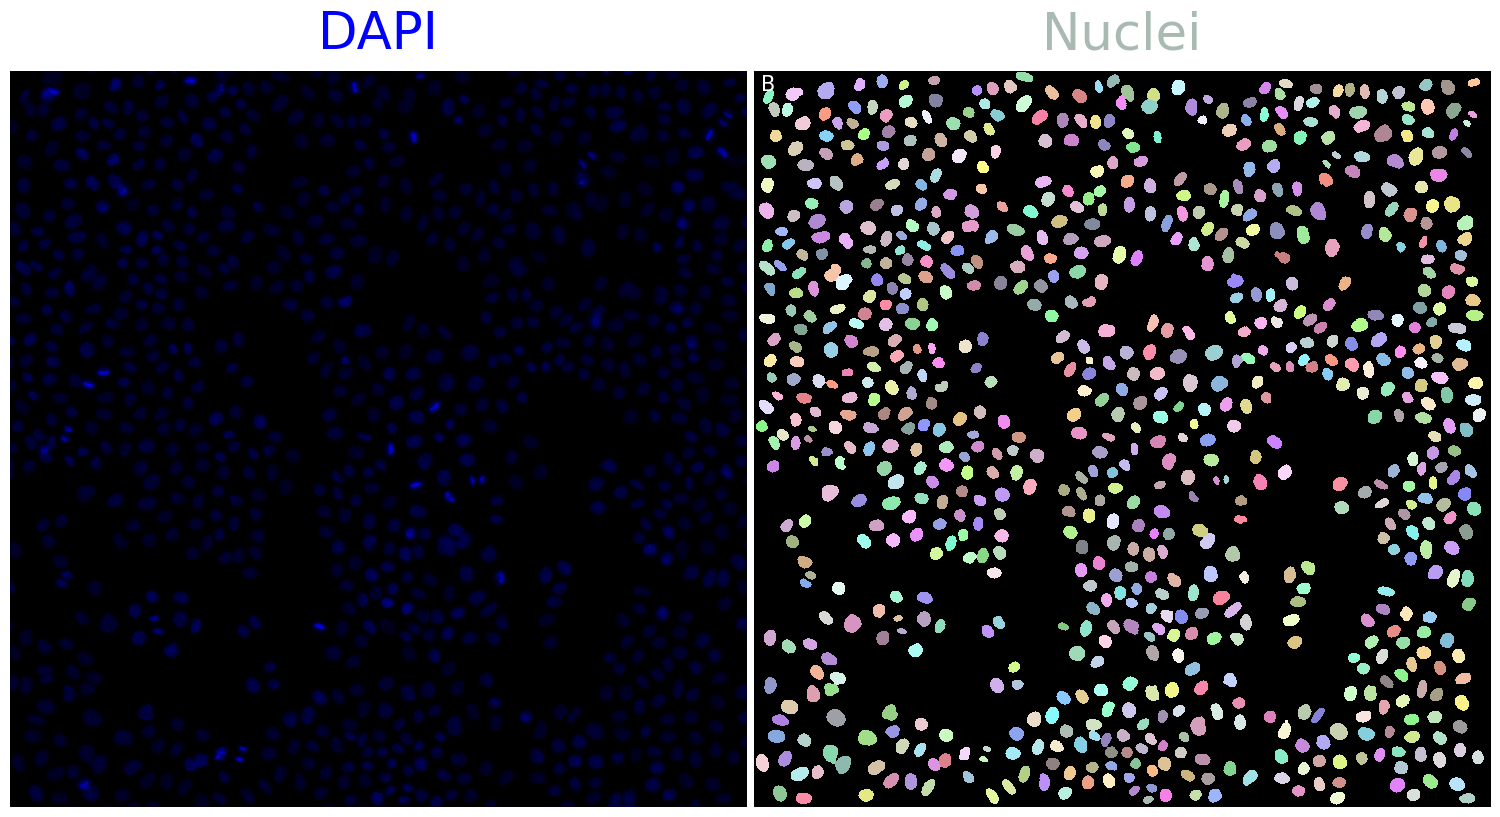

In [14]:
# Create microshow plots for each channel with specified colormaps and display ranges
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_microshow = microplot.Microimage(nuclei, 
                                        label_text='B',
                                        cmaps = nuclei_cmap,
                                        channel_names='Nuclei')

panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0,0], ph0_microshow);
panel.add_element([0,1], nuclei_microshow);
panel.add_channel_label()

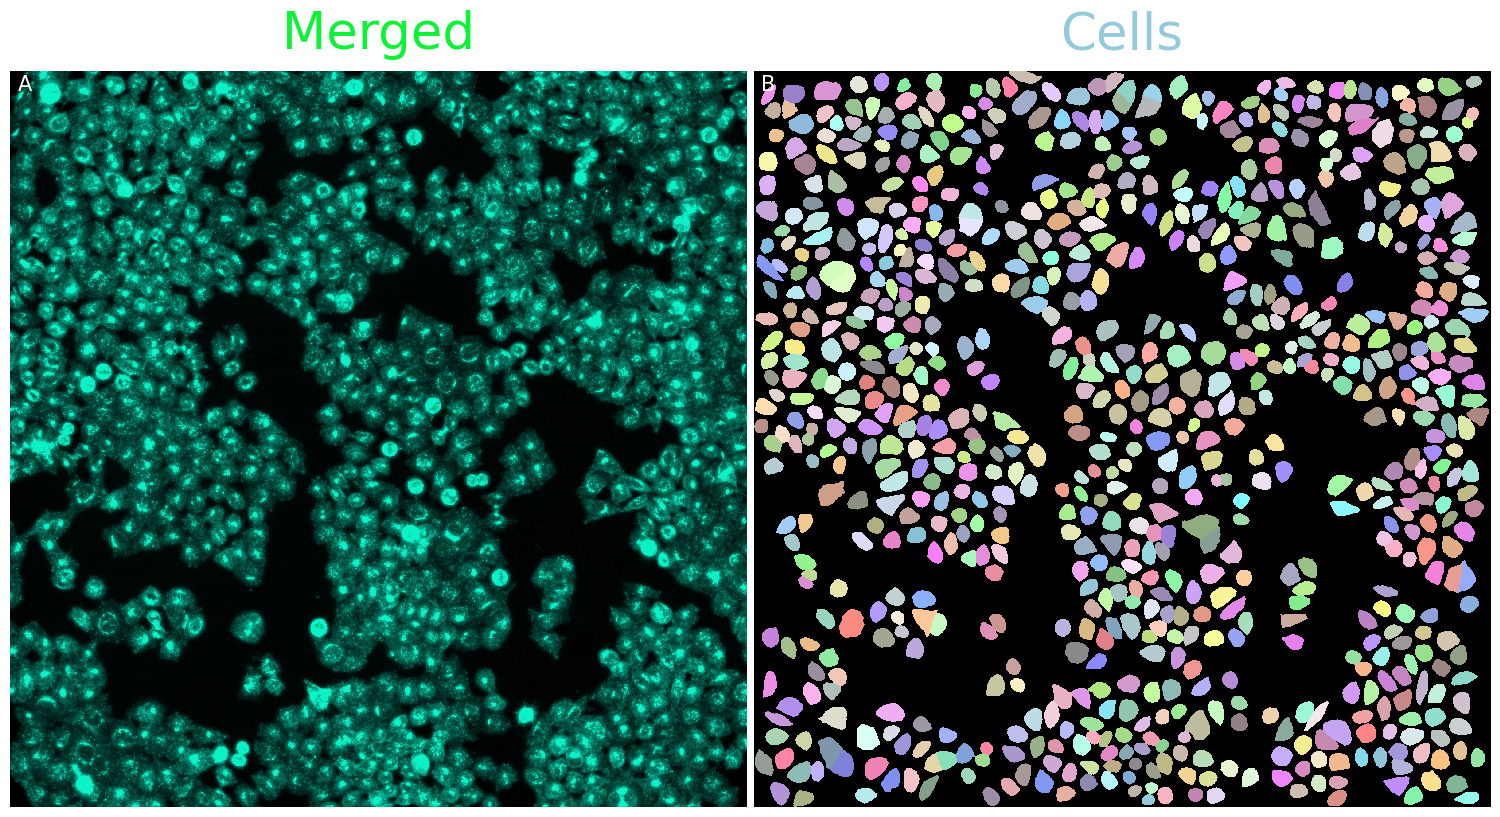

In [15]:
# Create microshow plots for each channel with specified colormaps and display ranges
all_microshow = microplot.Microimage(corrected_image,
                                     rescale_type='limits', 
                                     limits=DISPLAY_RANGES,
                                     label_text='A',
                                     channel_names='Merged')

cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_microshow = microplot.Microimage(cells,
                                       label_text='B',
                                       cmaps = cells_cmap,
                                       channel_names='Cells')

panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0,0], all_microshow);
panel.add_element([0,1], cells_microshow);
panel.add_channel_label()

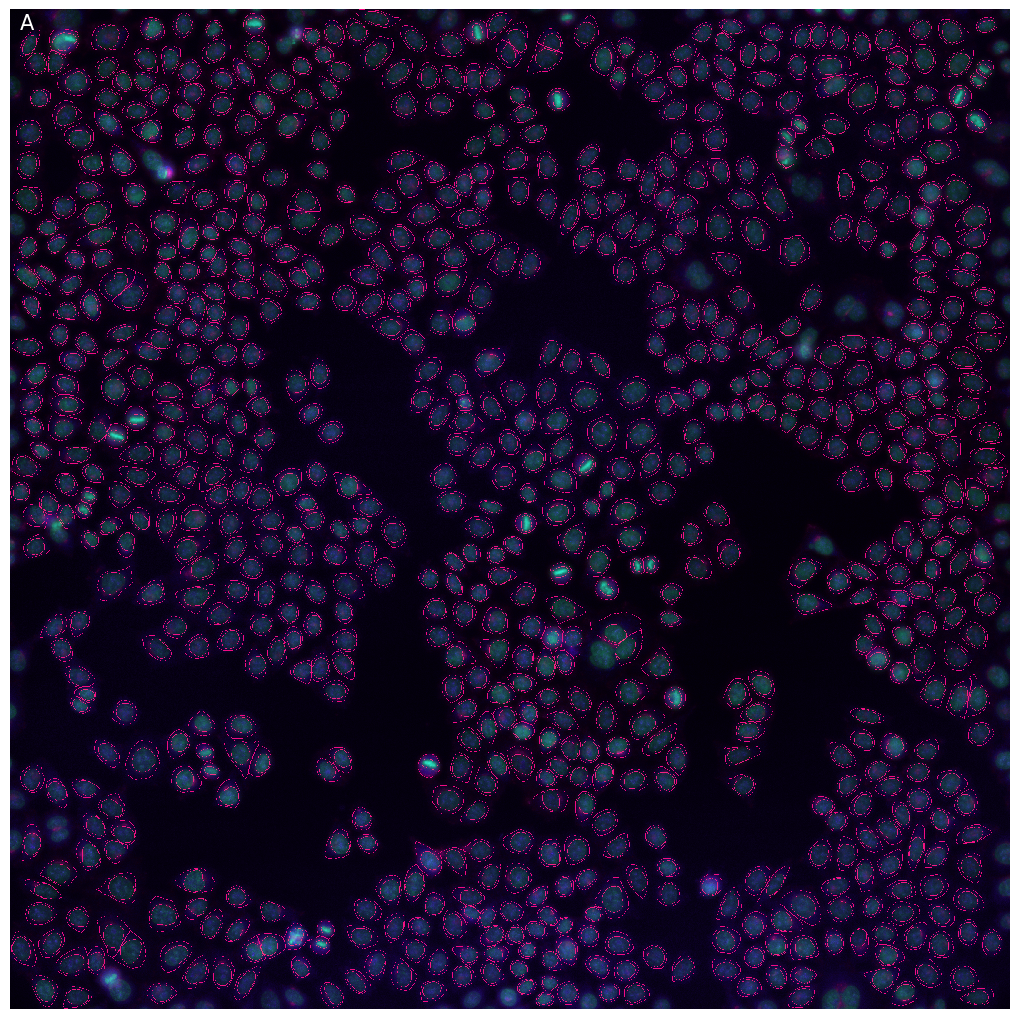

In [17]:
# Create microshow from annotated data
annotated_data=Snake._annotate_on_phenotyping_data(corrected_image, nuclei, cells)
save(name(description, tag='segmentation', subdir='ph_2/tif'), annotated_data)
annotated_microshow = microplot.Microimage(annotated_data,
                                           label_text='A',
                                           channel_names='Merged')
panel = Micropanel(rows=1, cols=1, figscaling=10)
panel.add_element([0,0], annotated_microshow);

In [18]:
# This corresponds to the 'segment_cytoplasm' rule in Snakemake
if SEGMENT_METHOD == "cellpose":
    cytoplasms = Snake._identify_cytoplasm_cellpose(nuclei, cells)
elif SEGMENT_METHOD in ["cell_2019", "cell_2022"]:
    cytoplasms = Snake._identify_cytoplasm(nuclei, cells)
else:
    raise ValueError(f"Invalid SEGMENT_METHOD: {SEGMENT_METHOD}. Choose 'cellpose', 'cell_2022', or 'cell_2019'.")

Number of cytoplasms identified: 805


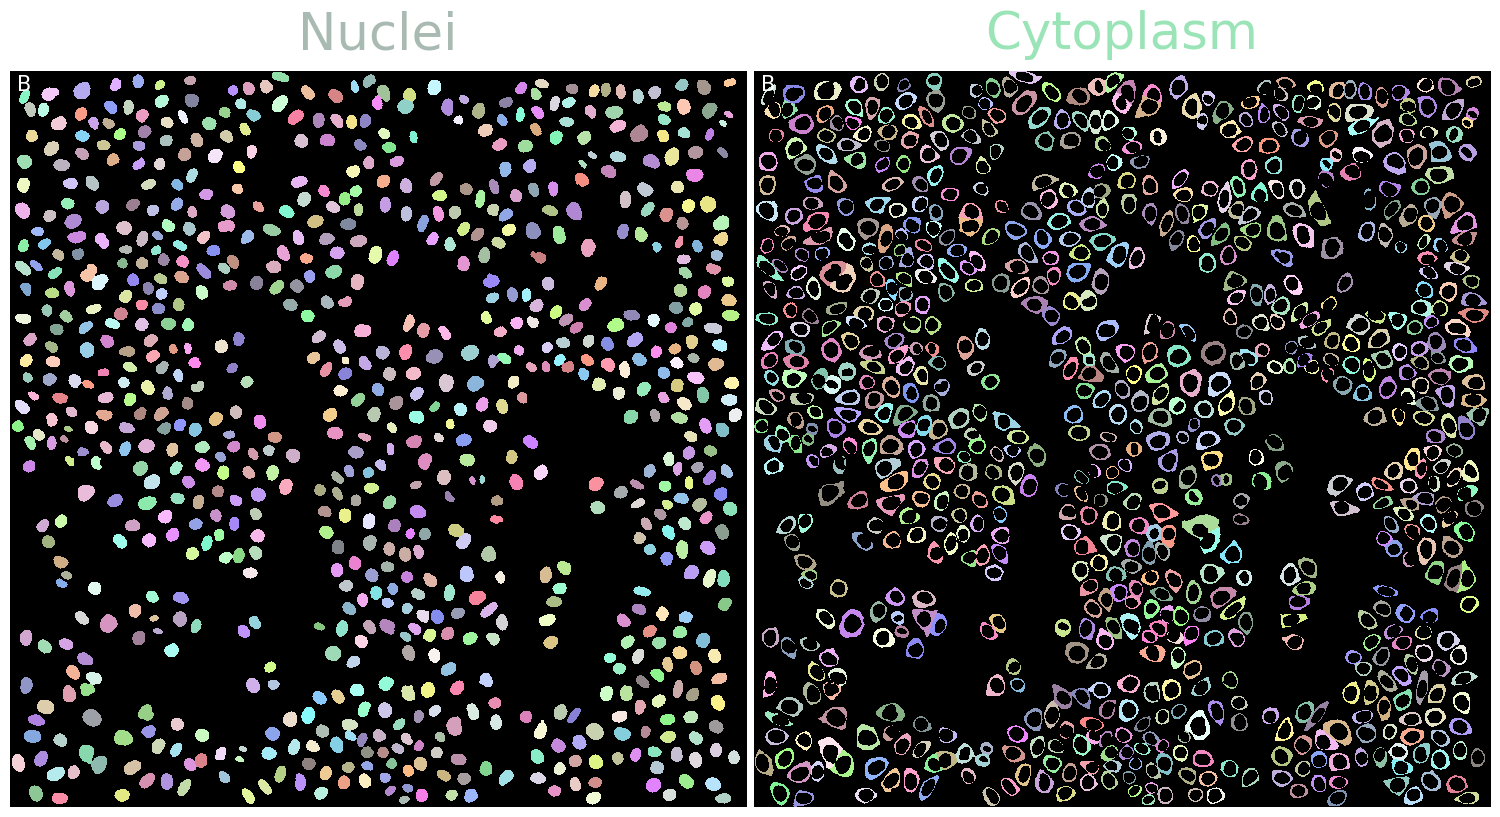

In [19]:
# Create microshow plots for cytoplasms relative to nuclei
cytoplasm_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasm_microshow = microplot.Microimage(cytoplasms,
                                           label_text='B',
                                           cmaps = cytoplasm_cmap,
                                           channel_names='Cytoplasm')
panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0,0], nuclei_microshow);
panel.add_element([0,1], cytoplasm_microshow);
panel.add_channel_label()

##### extract phenotype information

In [20]:
# This corresponds to the 'phenotype_info' rule in Snakemake
df_ph_info = Snake._extract_phenotype_minimal(data_phenotype=nuclei, nuclei=nuclei, wildcards=WILDCARDS)
df_ph_info.to_csv(name(description, tag='ph_info', ext='csv', subdir='ph_2/csv'), index=None)
df_ph_info

area            i            j  cell                    bounds  tile well
0    1426    21.860449   879.945302     1         (6, 852, 39, 909)   186   A1
1    1315    36.683650   416.812167     2        (14, 398, 60, 436)   186   A1
2    1317    35.067578  1169.242217     3      (14, 1149, 58, 1191)   186   A1
3     911    34.118551   586.324918     4        (20, 567, 49, 606)   186   A1
4    1200    47.324167   344.040000     5        (26, 326, 69, 363)   186   A1
..    ...          ...          ...   ...                       ...   ...  ...
800  1094  2360.717550  1437.792505   801  (2344, 1418, 2379, 1458)   186   A1
801  1573  2370.190083  1900.102352   802  (2350, 1876, 2392, 1925)   186   A1
802  1562  2370.784251   161.631242   803    (2352, 136, 2389, 189)   186   A1
803  1346  2371.769688  2322.800149   804  (2356, 2295, 2389, 2349)   186   A1
804   702  2376.229345  1282.924501   805  (2364, 1265, 2390, 1301)   186   A1

[805 rows x 7 columns]

The following cell contains important variables for feature extraction from the phenotyping images. Please review and adjust these variables based on your specific experimental data before proceeding with the analysis.

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.

Ensure these variables accurately reflect the channel organization and content in your experimental data to guarantee effective feature extraction.

In [21]:
# Define cellpose parameters
FOCI_CHANNEL = 1
CHANNEL_NAMES = ['dapi','cenpa','coxiv','wga']

In [22]:
# This corresponds to the 'extract_phenotype_cp' rule in Snakemake
df_ph = Snake._extract_phenotype_cp_multichannel(data_phenotype=corrected_image, nuclei=nuclei, cells=cells, wildcards=WILDCARDS, cytoplasms=cytoplasms, foci_channel=FOCI_CHANNEL, channel_names=CHANNEL_NAMES)
df_ph.to_csv(name(description, tag='phenotype', ext='csv', subdir='ph_2/csv'), index=None)
df_ph

/lab/barcheese01/mdiberna/OpticalPooledScreens/ops/process.py:933: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


label  nucleus_dapi_int  nucleus_cenpa_int  nucleus_coxiv_int  \
0        1           4029607             358190             493216   
1        2           4459145             483572             559014   
2        3           4078088             445139             521770   
3        4           8754640             537519             567311   
4        5           8147211             522679             670595   
..     ...               ...                ...                ...   
800    801           4184558             463467             718264   
801    802           4376083             545547             840365   
802    803           4309909             359663             662040   
803    804           3959002             318144             561078   
804    805           3896187             292412             473116   

     nucleus_wga_int  nucleus_dapi_mean  nucleus_cenpa_mean  \
0            3841223        2825.811360          251.185133   
1            4053823        3390.984791          367.735361   
2            3609615        3096.498102          337.994685   
3            4440756        9609.923161          590.031833   
4            5070580        6789.342500          435.565833   
..               ...                ...                 ...   
800          4128145        3825.007313          423.644424   
801          5481580        2781.998093          346.819453   
802          4022188        2759.224712          230.258003   
803          3452411        2941.309064          236.362556   
804          2523504        5550.123932          416.541311   

     nucleus_coxiv_mean  nucleus_wga_mean  nucleus_dapi_std  ...  \
0            345.873773       2693.704769        494.750356  ...   
1            425.105703       3082.755133        571.610965  ...   
2            396.180714       2740.785877        547.228652  ...   
3            622.734358       4874.594951       4113.642700  ...   
4            558.829167       4225.483333       1509.843170  ...   
..                  ...               ...               ...  ...   
800          656.548446       3773.441499        716.424788  ...   
801          534.243484       3484.793388        416.096553  ...   
802          423.841229       2575.024328        484.819470  ...   
803          416.848440       2564.941308        525.581854  ...   
804          673.954416       3594.735043       1342.312708  ...   

     cell_number_neighbors_1  cell_percent_touching_1  \
0                          0                 0.000000   
1                          0                 0.000000   
2                          1                 0.160156   
3                          1                 0.092593   
4                          0                 0.000000   
..                       ...                      ...   
800                        0                 0.000000   
801                        0                 0.000000   
802                        0                 0.000000   
803                        0                 0.000000   
804                        0                 0.000000   

     cell_first_neighbor_distance  cell_second_neighbor_distance  \
0                       60.972014                      84.798241   
1                       73.422929                      74.219966   
2                       54.918588                      57.102864   
3                       63.310701                      99.804874   
4                       74.219966                      75.235996   
..                            ...                            ...   
800                     64.394853                      66.258694   
801                     52.593524                      77.249228   
802                     77.864521                      84.577667   
803                     58.223758                     132.803376   
804                     40.257158                      53.004333   

     cell_angle_between_neighbors  cytoplasm_number_neighbors_1  \
0                    

In [23]:
# Generate a summary of the number of cells
plot_count_heatmap(df_ph_info, shape='6W_sbs', return_plot=False, return_summary=True)

well  tile  count
0   A1   186    805